## classification model

In [7]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn

import pandas as pd
import numpy as np
import logging
from datasets import Dataset, DatasetDict
from transformers import DistilBertModel
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

COVERWALLET_DF_PATH = '../src/data/coverwallet.xlsx'
df = pd.read_excel(COVERWALLET_DF_PATH)
df = df.dropna()
def truncate_naics_and_prepare_data(df, column_name, num_digits):
    """
    Truncates the NAICS codes in the specified column to the desired number of digits and prepares the data.

    :param df: pandas DataFrame containing the NAICS codes.
    :param column_name: the name of the column with the NAICS codes.
    :param num_digits: the number of digits to truncate to.
    :return: A modified DataFrame with truncated NAICS codes, and split datasets for training and validation.
    """
    # Validate the number of digits
    if not isinstance(num_digits, int) or num_digits <= 0:
        logging.error("Number of digits must be a positive integer")
        raise ValueError("Number of digits must be a positive integer")

    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Function to truncate or pad NAICS codes
    def truncate_code(code):
        """
        Truncates the NAICS code to the specified number of digits.
        :param code: the NAICS code to be truncated.
        :return: The truncated NAICS code as a string.
        """
        try:
            # Ensure the code is a string and truncate if longer than num_digits
            return str(code)[:num_digits]
        except Exception as e:
            logging.exception(f"Error truncating code: {code}")
            return code

    # Apply the truncation function to the specified column
    df_copy[column_name] = df_copy[column_name].apply(truncate_code)

    # Ensure all NAICS codes are still strings
    df_copy[column_name] = df_copy[column_name].astype(str)

    # Add a logging statement to check the result
    logging.info("NAICS codes processed successfully. Here's the head of the processed DataFrame:")
    logging.info(df_copy.head())

    # Split the data into training and validation sets
    df_copy_train, df_copy_val = train_test_split(df_copy, test_size=0.15, shuffle=True, random_state=42)

    # Return the processed DataFrame and the split datasets
    return df_copy, df_copy_train, df_copy_val
'''
    # Configuration k-fold
    num_folds = 3
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    kfold_datasets = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset_train)):
        train_dataset = dataset_train.select(train_indices)
        val_dataset = dataset_train.select(val_indices)

        dataset_dict = {
            'train': train_dataset,
            'validation': val_dataset
        }

        features_dict = {
            "NAICS": dataset_train["NAICS"],
            "BUSINESS_DESCRIPTION": dataset_train["BUSINESS_DESCRIPTION"],
        }

        kfold_datasets.append(dataset_dict)
        logging.info(f"Processed fold {fold + 1}")

    for i, dataset_dict in enumerate(kfold_datasets):
        for split in dataset_dict.keys():
            dataset_dict[split] = dataset_dict[split].map(lambda example: {key: example[key] for key in features_dict.keys()})

        logging.info(f"DatasetDict for Fold {i + 1}:")
        for split, dataset in dataset_dict.items():
            logging.info(f"  {split} split: {dataset}")

    logging.info("NAICS codes truncated successfully. Here's the head of the truncated DataFrame:")
    logging.info("\n%s", df_copy.head())
    logging.info("Number of unique NAICS labels: %d", len(labels))
    '''
    #return df_copy, kfold_datasets, dataset_train, dataset_final_val

    #df_2_digits, kfold_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)
df_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)

INFO: NAICS codes processed successfully. Here's the head of the processed DataFrame:
INFO:   NAICS                               BUSINESS_DESCRIPTION
0    72  Zenyai Viet Cajun & Pho Restaurant is dedicate...
1    54  Kilduff Underground Engineering, Inc. (KUE) is...
2    45  024™ is a premium home fragrance brand that de...
3    56  Our Services include Office Cleaning Carpet cl...
4    62                    NYS Licensed Home Health Agency


In [8]:
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn

class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = np.array(dataframe['BUSINESS_DESCRIPTION'].astype(str))
        self.targets = np.array(dataframe['label'])
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Agregar una capa de clasificación que será la única que entrenemos
        self.classifier = nn.Linear(self.model.config.dim, len(np.unique(self.targets)))

        # Congelar todos los parámetros del modelo DistilBERT
        for param in self.model.parameters():
            param.requires_grad = False

        # Habilitar entrenamiento solo en la capa clasificadora
        for param in self.classifier.parameters():
            param.requires_grad = True

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]

        # Tokenizar el texto y obtener los embeddings con el modelo DistilBERT
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Obtener los embeddings del token [CLS] (última capa oculta)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Embeddings del token [CLS]

        # Aquí simplemente extraemos los embeddings después de haber sido procesados por la capa de clasificación,
        # pero no utilizamos los logits para clasificación directa en este paso.
        # Si deseas ver el efecto de la capa clasificadora, podrías calcular los logits y luego ignorarlos:
        logits = self.classifier(embeddings)  # Esto entrenará la capa con los gradientes apropiados durante el entrenamiento

        label = torch.tensor(target, dtype=torch.long)

        return {
            'embeddings': embeddings,  # Devolver embeddings del token [CLS]
            'label': label
        }

In [10]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [11]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05
train_size = 0.7
test_size = 0.2
val_size = 0.1
df_2_digits.rename(columns={'NAICS': 'label'}, inplace=True)
df_2_digits['label'], _ = pd.factorize(df_2_digits['label'])
train_data = df_2_digits.sample(frac=train_size, random_state=200)
remaining_data = df_2_digits.drop(train_data.index).reset_index(drop=True)
test_data = remaining_data.sample(frac=test_size / (test_size + val_size), random_state=200)
val_data = remaining_data.drop(test_data.index).reset_index(drop=True)

def dataset_to_dataframe(dataset):
    data = []
    for i in range(len(dataset)):
        item = dataset[i]
        # Assume each item returns a dictionary with 'embeddings' and 'label'
        embeddings = item['embeddings'].numpy()  # Converting tensor to numpy array
        label = item['label'].item()  # Getting the scalar value of the label tensor
        # You may want to store more meaningful data depending on your application
        # For demonstration, we'll just store the label and the shape of the embeddings
        data.append({
            'label': label,
            'embeddings': embeddings  # Storing just the shape for simplicity
        })
    return pd.DataFrame(data)

# Assuming the CustomDataset, MAX_LEN, and other variables are set up properly


training_set = CustomDataset(train_data, MAX_LEN)
test_set = CustomDataset(test_data, MAX_LEN)
val_set = CustomDataset(val_data, MAX_LEN)

# Convert datasets to DataFrames
df_training = dataset_to_dataframe(training_set)
df_test = dataset_to_dataframe(test_set)
df_val = dataset_to_dataframe(val_set)

logging.info("TRAIN Dataset: %s", df_training.head())
logging.info("TEST Dataset: %s", df_test.head())
logging.info("VALIDATION Dataset: %s", df_val.head())


INFO: TRAIN Dataset:    label                                         embeddings
0      1  [[-0.06241003, 0.053661536, -0.27193546, 0.117...
1      1  [[-0.024929492, -0.13341404, -0.33938393, -0.3...
2      1  [[-0.24962023, -0.019333987, -0.16619137, -0.0...
3     19  [[-0.39253598, -0.20841603, -0.47992826, -0.10...
4      0  [[-0.2193796, -0.092968725, -0.39098755, 0.042...
INFO: TEST Dataset:    label                                         embeddings
0     19  [[-0.011569395, 0.0067163473, -0.015970893, 0....
1     10  [[-0.1838254, 0.10681253, -0.37988612, -0.0676...
2      5  [[-0.045074083, 0.20381601, -0.17560533, -0.18...
3      3  [[-0.18686955, -0.0041282703, -0.5417208, 0.02...
4      5  [[-0.2674725, 0.0045474526, -0.3465195, -0.270...
INFO: VALIDATION Dataset:    label                                         embeddings
0      1  [[-0.16128156, 0.053350013, -0.04042377, -0.01...
1     15  [[-0.23275359, -0.017413035, -0.2841873, 0.126...
2      1  [[-0.12907067, 0.028699

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Confusion Matrix:
 [[ 23   1   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1 344   2   8   3  14   4   0   0   0   0   0   9   3   1   0   2   4
    1   1   0   0   0   0]
 [  0   2   8   0   3   1   0   0   0   0   1   0   1   0   3   0   1   0
    0   7   1   0   0   0]
 [  0  19   1  79   1  12   0   0   0   0   1   0   0   0   1   0   0   2
    0   4   0   0   1   0]
 [  1   8   0   2  36   0   0   0   0   1   0   0   0   0   1   0   6   0
    0   0   0   0   0   0]
 [  0  12   0   7   0 265   1   0   0   1   0   0   1   1   7   0   0   2
    0   3   0   0   0   0]
 [  0   5   0   1   1   0   8   0   0   0   1   0   3   2   0   0   2   0
    0   0   0   0   0   0]
 [  5   0   1   0   0   0   0  12   0   0   0   0   0   0   2   0   0   0
    0   4   1   0   0   0]
 [  0   0   0   0   0   1   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  1   0   1   0   0   1   0   0   0   2   0   0   0   0   1   0   0   

/tmp/ipykernel_1236/367614452.py:47: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
/tmp/ipykernel_1236/367614452.py:47: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
/tmp/ipykernel_1236/367614452.py:47: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
/tmp/ipykernel_1236/367614452.py:47: RuntimeWarning: invalid value encountered in divide
  f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))


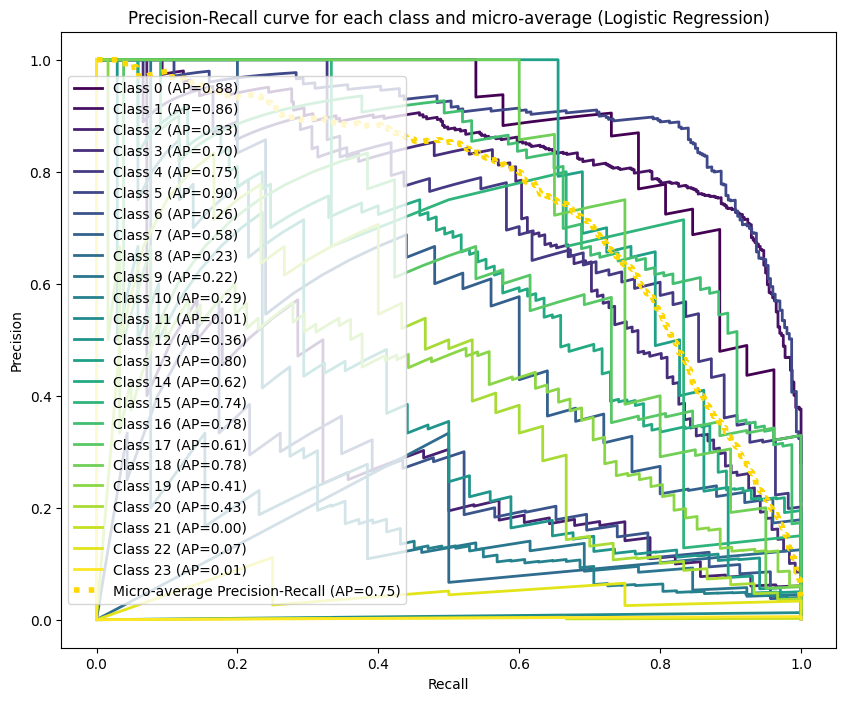

INFO: Average F1 Score Logistic Regression: 0.510775


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Preparar los datos, entrenar el modelo y hacer predicciones
X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()
X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)

# Generar matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)
logging.info("F1 Score: %f", f1)

# Binarizar las etiquetas en un formato one-vs-all
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

# Calcular precisión, recall y F1 para cada clase
precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(np.unique(y_val)))))
plt.figure(figsize=(10, 8))

for i in range(len(np.unique(y_val))):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=next(colors), lw=2,
             label='Class {0} (AP={1:0.2f})'.format(i, average_precision[i]))

# Calcular y graficar el micro-average de la curva de precisión-recall
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Logistic Regression)')
plt.legend(loc="best")
plt.show()

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Logistic Regression: %f", f1_average)


random forest

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Confusion Matrix:
 [[ 14   4   0   2   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   2   0   0   0   0]
 [  0 372   0   4   0  18   0   0   0   0   0   0   0   0   1   0   2   0
    0   0   0   0   0   0]
 [  1   8   2   1   2   5   0   0   0   0   1   0   0   0   2   0   2   0
    0   4   0   0   0   0]
 [  1  47   0  48   0  24   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0]
 [  0  19   0   1  21   3   0   0   0   0   0   0   0   0   0   0  10   0
    0   1   0   0   0   0]
 [  0  28   0   1   0 267   0   0   0   0   0   0   0   0   2   0   0   0
    0   2   0   0   0   0]
 [  1  18   0   0   0   0   1   0   0   0   0   0   0   0   0   0   3   0
    0   0   0   0   0   0]
 [  5   5   1   2   0   2   0   1   0   0   0   0   0   0   5   0   0   0
    0   4   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  4   3   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0   

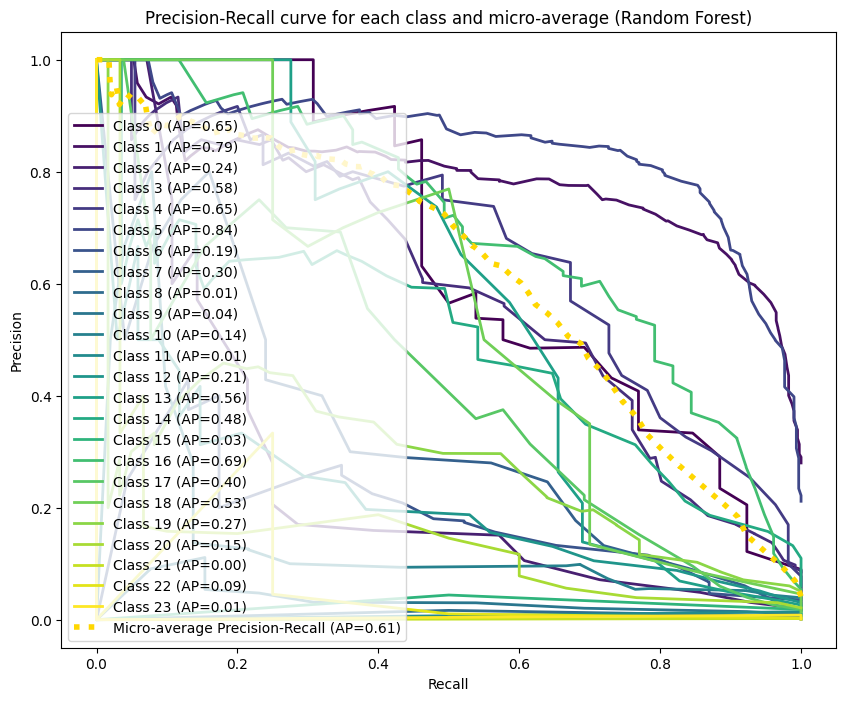

INFO: Average F1 Score Random Forest: 0.371562


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Código para aplanar los embeddings y extraer las etiquetas aquí...

# Entrenar el modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred = rf_model.predict(X_val)
y_val_proba = rf_model.predict_proba(X_val)

# Matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report Random Forest:\n", report)
logging.info("F1 Score Random Forest: %f", f1)

# Binarizar las etiquetas en un formato one-vs-all para Random Forest
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

# Establecer el "ciclo" de colores para que coincida con el número de clases
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(np.unique(y_val)))))

# Calcular precisión y recall para cada clase
precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

for i in range(len(np.unique(y_val))):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    # Asegúrate de que no haya división por cero al calcular el F1 score
    if np.any(precision[i]) and np.any(recall[i]):
        f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
        f1_scores.append(np.nanmax(f1))
    else:
        f1_scores.append(0)

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(10, 8))
for i, color in zip(range(len(np.unique(y_val))), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Class {0} (AP={1:0.2f})'.format(i, average_precision[i]))

# Calcular la precisión y el recall promedios (micro-average)
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

# Graficar la curva de precisión-recall promedio
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Random Forest)')
plt.legend(loc="best")
plt.show()

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Random Forest: %f", f1_average)

svm

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Confusion Matrix:
 [[ 21   2   0   2   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 369   1   2   1  17   2   0   0   0   0   0   0   0   2   0   2   1
    0   0   0   0   0   0]
 [  0   4   7   0   2   2   0   0   0   0   1   0   0   0   4   0   2   0
    0   6   0   0   0   0]
 [  0  33   0  67   0  14   0   0   0   0   0   0   0   0   2   0   0   1
    0   4   0   0   0   0]
 [  0  12   0   1  35   0   0   0   0   0   0   0   0   0   0   0   6   0
    0   1   0   0   0   0]
 [  0  21   0   3   0 269   0   0   0   0   0   0   0   0   3   0   0   2
    0   2   0   0   0   0]
 [  1  12   2   0   1   0   5   0   0   0   0   0   0   0   0   0   2   0
    0   0   0   0   0   0]
 [  4   2   1   1   0   0   0   4   0   0   0   0   0   0   2   0   0   0
    0  11   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  4   2   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   

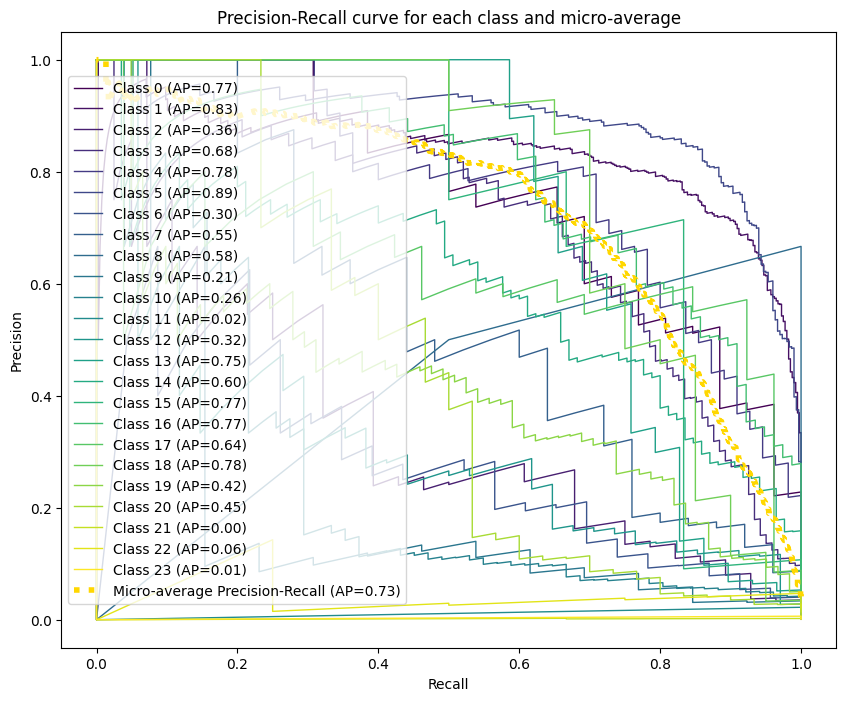

INFO: Average F1 Score SVM: nan


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import logging
from itertools import cycle
# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Aplanar los embeddings y extraer las etiquetas
X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_test = np.stack(df_test['embeddings'].apply(lambda x: np.array(x).flatten()))
y_test = df_test['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

# Entrenar el modelo SVM
model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)  # SVM también puede proporcionar probabilidades

# Matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report SVM:\n", report)
logging.info("F1 Score SVM: %f", f1)


#USA ESTE CODIGO Y ADAPTALO PARA RANDOM FOREST Y PARA LOGISTIC REGRESSION. LITERLAMENTE
#ADAPTA EL CODIGO ENTERO PARA DECISION TREES,GBM,CLASSIFIER CHAIN (PARA TENER CORRELACION ENTRE CADENAS)

y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

# Calcular precisión y recall para cada clase usando predict_proba
precision = dict()
recall = dict()
average_precision = dict()
thresholds = dict()

for i in range(len(np.unique(y_val))):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(10, 8))

# Establecer el "ciclo" de colores para que coincida con el número de clases
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(np.unique(y_val)))))

f1_scores = []
for i, color in zip(range(len(np.unique(y_val))), colors):
    plt.plot(recall[i], precision[i], color=color, lw=1,
             label='Class {0} (AP={1:0.2f})'.format(i, average_precision[i]))
    f1 = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    f1_scores.append(f1[np.argmax(f1)])

# Calcular la precisión y el recall promedios (micro-average)
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

# Graficar la curva de precisión-recall promedio
plt.plot(recall["micro"], precision["micro"],
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]),
         color='gold', linestyle=':', linewidth=4)

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average')
plt.legend(loc="best")
plt.show()

logging.info("Average F1 Score SVM: %f", f1_average)

lda

/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Confusion Matrix:
 [[ 18   2   0   0   0   0   0   1   0   1   2   0   0   0   0   0   0   0
    0   2   0   0   0   0]
 [  0 335   1   5   2  10   5   0   1   1   1   3  10   6   3   0   5   3
    4   2   0   0   0   0]
 [  0   2   9   0   3   1   0   1   0   0   1   0   0   0   2   0   2   0
    0   7   0   0   0   0]
 [  0  22   1  76   1   8   0   0   0   0   2   0   2   0   2   0   0   2
    0   3   0   0   2   0]
 [  0   6   0   0  41   0   1   0   0   0   0   0   1   0   1   0   5   0
    0   0   0   0   0   0]
 [  0  10   1   7   0 259   1   0   2   0   3   0   1   1   6   0   0   2
    0   7   0   0   0   0]
 [  1   4   2   0   0   0   9   0   0   0   0   0   4   0   0   0   3   0
    0   0   0   0   0   0]
 [  3   0   1   0   0   0   0  15   0   0   1   0   0   0   2   0   0   0
    0   1   2   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   1   0   0   0   1   0   0   0   5   1   0   0   0   0   0   0   

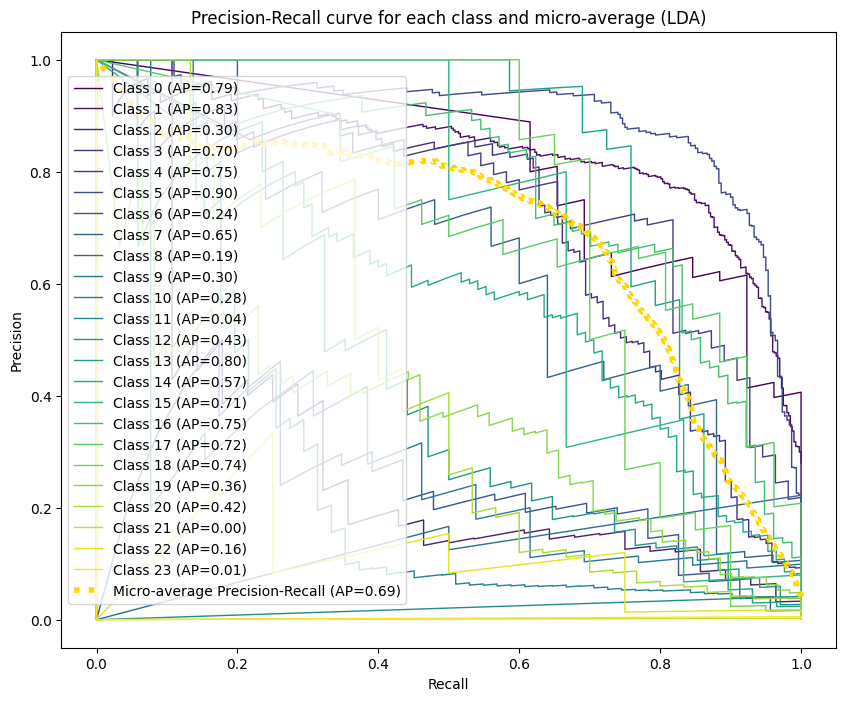

INFO: Average F1 Score LDA: 0.517727


In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
import logging


# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Aplanar los embeddings y extraer las etiquetas
X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_test = np.stack(df_test['embeddings'].apply(lambda x: np.array(x).flatten()))
y_test = df_test['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

# Entrenar el modelo LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Predicciones en el conjunto de validación
y_val_pred = lda_model.predict(X_val)
y_val_proba = lda_model.predict_proba(X_val)

# Matriz de confusión y reporte de clasificación
conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report LDA:\n", report)
logging.info("F1 Score LDA: %f", f1)

# Calcular precisión y recall para cada clase usando predict_proba
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))

# Establecer el "ciclo" de colores para que coincida con el número de clases
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(np.unique(y_val)))))

# Calcular precisión, recall y F1 para cada clase
precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

for i in range(len(np.unique(y_val))):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))  # Solo guarda el valor máximo de F1 para cada clase

# Graficar la curva de precisión-recall para cada clase
plt.figure(figsize=(10, 8))
for i, color in zip(range(len(np.unique(y_val))), colors):
    plt.plot(recall[i], precision[i], color=color, lw=1,
             label='Class {0} (AP={1:0.2f})'.format(i, average_precision[i]))

# Calcular la precisión y el recall promedios (micro-average) y graficar la curva promedio
precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))

# Añadir el F1-score promedio al logging
f1_average = np.mean(f1_scores)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (LDA)')
plt.legend(loc="best")
plt.show()
logging.info("Average F1 Score LDA: %f", f1_average)